### Imports and hyperparameters

In [3]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import accuracy_score

import os

from transformers import AutoTokenizer, TFAutoModel, create_optimizer

import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
MAX_SEQUENCE_LENGTH = 100
EPOCHS = 5
DROPOUT = 0.2
LEARNING_RATE = 3e-5
BATCH_SIZE = 32
NUM_WARMUP_STEPS = 100

# Set a seed to decrease randomness
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Load train and development datasets

In [4]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('dev.csv')

### Set up tokenizer for DeBERTa model

In [5]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Plotting lengths of token in training dataset

In [6]:
x = tokenizer(train.premise.values.tolist(), train.hypothesis.values.tolist(), truncation=True, max_length=200)

In [7]:
lengths = []

for ex in x['input_ids']:
  lengths.append(len(ex))

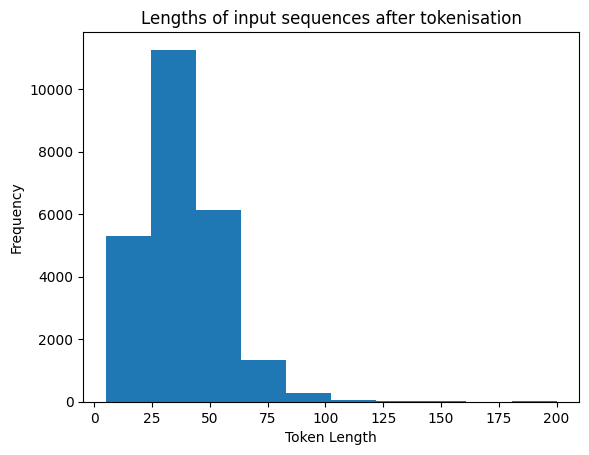

In [8]:
plt.hist(lengths, bins=10)
plt.title('Lengths of input sequences after tokenisation')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

### Tokenising and preparing inputs

In [ ]:
# Encode data with a max length of 100
def bert_encode(hypotheses, premises, tokenizer, max_length=MAX_SEQUENCE_LENGTH):

    x = tokenizer(hypotheses, premises, padding='max_length', truncation=True, max_length=max_length)

    inputs = {
          'input_word_ids':tf.ragged.constant(x['input_ids']).to_tensor(),
          'input_mask': tf.ragged.constant(x['attention_mask']).to_tensor(),
          'input_type_ids': tf.ragged.constant(x['token_type_ids']).to_tensor()}

    return inputs


In [10]:
train_input = bert_encode(train.premise.values.tolist(), train.hypothesis.values.tolist(), tokenizer)

In [12]:
valid_input = bert_encode(valid.premise.values.tolist(), valid.hypothesis.values.tolist(), tokenizer)

### Define model

In [5]:
os.environ["WANDB_API_KEY"] = "0"

def build_model():
    bert_encoder = TFAutoModel.from_pretrained("microsoft/deberta-v3-base")
    input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_type_ids")

    output = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.GlobalAveragePooling1D()(output)

    output = tf.keras.layers.Dropout(DROPOUT)(output)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)

    return model

In [6]:
model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/736M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                              

In [11]:
# Create tensorflow datasets for training and validation, with a batch size of 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train.label.values.reshape(-1,1)))
train_dataset = train_dataset.shuffle(42, reshuffle_each_iteration=True).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_input, valid.label.values.reshape(-1,1)))
valid_dataset = valid_dataset.batch(BATCH_SIZE)

In [ ]:
num_train_steps = (len(train.label.values) // BATCH_SIZE) * EPOCHS

# Create Adam optimiser with weight decay and linear warmup schedule
optimizer, lr_schedule = create_optimizer(
    init_lr=LEARNING_RATE,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=NUM_WARMUP_STEPS,
)

In [13]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Create callback to save the model with the highest validation accuracy

checkpoint_filepath = 'best.model.weights.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True)

### Training the model

In [15]:
history = model.fit(
    train_dataset,
    epochs = 5,
    verbose = 1,
    validation_data = valid_dataset,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/5


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


764/764 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8555

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


764/764 [==============================] - 862s 1s/step - loss: 0.3377 - accuracy: 0.8555 - val_loss: 0.2390 - val_accuracy: 0.9080
Epoch 2/5
764/764 [==============================] - 817s 1s/step - loss: 0.1294 - accuracy: 0.9551 - val_loss: 0.2692 - val_accuracy: 0.9140
Epoch 3/5
764/764 [==============================] - 817s 1s/step - loss: 0.0599 - accuracy: 0.9816 - val_loss: 0.3287 - val_accuracy: 0.9216
Epoch 4/5
764/764 [==============================] - 806s 1s/step - loss: 0.0316 - accuracy: 0.9907 - val_loss: 0.3569 - val_accuracy: 0.9210
Epoch 5/5
764/764 [==============================] - 817s 1s/step - loss: 0.0166 - accuracy: 0.9960 - val_loss: 0.3935 - val_accuracy: 0.9234


## Hyperparameter Tuning

Note that due to memory limitations in the free version of colab (T4 GPU), we limit the number of trials to 3. The explored hyperparameters and obtained accuracies are then stored in a pickle file. Once the session is terminated and restarted, the pickle file is loaded and hyperparameter tuning is resumed.

In [ ]:
def model_init(dropout, learning_rate, num_warmup_steps, batch_size):
    bert_encoder = TFAutoModel.from_pretrained("microsoft/deberta-v3-base")
    input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_type_ids")

    output = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.GlobalAveragePooling1D()(output)
    output = tf.keras.layers.Dropout(dropout)(output)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)

    epochs = EPOCHS
    num_train_steps = (len(train.label.values) // batch_size) * epochs

    optimizer, lr_schedule = create_optimizer(
            init_lr=tf.cast(learning_rate, tf.float32),
            num_train_steps=num_train_steps,
            weight_decay_rate=0.01,
            num_warmup_steps=num_warmup_steps
        )

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [17]:
# Hyperparameter space to search
hp_space = {
    "dropout": [0.0,0.1,0.15],
    "learning_rate": [1e-5,1.5e-5,2e-5, 2.5e-5, 3e-5],
    "batch_size": [8,16,32],
    "num_warmup_steps": [50,100,500,1000]
}

In [ ]:
num_trials = 3
hps = []
accuracies = []
trial_count = 0

if os.path.exists('tuning.pkl'):
  with open('tuning.pkl', 'rb') as f:
      tuning = pickle.load(f)
      hps = tuning['hps']
      accuracies = tuning['accuracies']

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

while trial_count < num_trials:
    tf.keras.backend.clear_session()

    dropout = np.random.choice(hp_space['dropout'])
    learning_rate = np.random.choice(hp_space['learning_rate'])
    batch_size = np.random.choice(hp_space['batch_size'])
    num_warmup_steps = np.random.choice(hp_space['num_warmup_steps'])

    current_trial = {
        "dropout": dropout,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "num_warmup_steps": num_warmup_steps
    }

    if current_trial not in hps:
        hps.append(current_trial)
    else:
        continue

    print(f"Trial {trial_count+1}/{num_trials}")
    print(f"Dropout: {dropout}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Batch Size: {batch_size}")
    print(f"Num Warmup Steps: {num_warmup_steps}")

    model = model_init(dropout, learning_rate, num_warmup_steps, batch_size)

    train_ds = tf.data.Dataset.from_tensor_slices((train_input, train.label.values.reshape(-1,1)))
    train_ds = train_ds.shuffle(42, reshuffle_each_iteration=True).batch(batch_size)

    valid_ds = tf.data.Dataset.from_tensor_slices((valid_input, valid.label.values.reshape(-1,1)))
    valid_ds = valid_ds.batch(batch_size)

    model.fit(
        train_ds,
        epochs = 5,
        verbose = 1,
        validation_data = valid_ds,
        callbacks=[early_stopping]
    )

    outputs = model.predict(valid_input)

    preds = outputs > 0.5
    labels = valid.label.values.reshape(-1,1)

    accuracy = accuracy_score(labels, preds)
    accuracies.append(accuracy)

    trial_count += 1

### Save search hyperparameters and obtained accuracies in a pickle file

In [21]:
tuning = {'hps': hps, 'accuracies': accuracies}

with open('tuning.pkl', 'wb') as f:
    pickle.dump(tuning, f)

### Once hyperparameter tuning is completed, running the following cells to display the top 3 hyperparameters

In [ ]:
with open('tuning.pkl', 'rb') as f:
    tuning = pickle.load(f)
    hps = tuning['hps']
    accuracies = tuning['accuracies']

In [27]:
indexes = list(range(len(accuracies)))
indexes.sort(key=lambda i: accuracies[i], reverse=True)

In [ ]:
# Top 3 hps
for i in indexes[:3]:
    print(accuracies[i], hps[i])